In [ ]:
# default_exp augment.tensor_item_tfm

In [ ]:
#hide
from nbdev.showdoc import *

# TensorImage & TensorMask item transforms
> Adds support for resizing and cropping `TensorImage` and `TensorMask` as an `item_tfm` to fast.ai.

In [ ]:
#export
from torchvision.transforms.functional import pad as tvpad
from torchvision.transforms.functional import _interpolation_modes_from_int
from torch.nn.functional import interpolate
from fastai.vision.augment import RandomCrop, CropPad, Resize, PadMode, RandomResizedCrop, RatioResize, ResizeMethod, _pad_modes, _get_sz
from fastai.vision.core import TensorImage, TensorMask
from fastcore.basics import fastuple
from fastcore.foundation import patch
from PIL import Image
import operator

In [ ]:
#hide
from fastai.vision.core import PILImage, image2tensor
import matplotlib.pyplot as plt
from fastai.data.transforms import IntToFloatTensor

itft = IntToFloatTensor()
img = itft(TensorImage(image2tensor(PILImage.create('images/puppy.jpg').resize((600,400)))).float())

## Implementation Patches and Methods
Augmentations patched: `RandomCrop`, `CropPad`, `Resize`, `RandomResizedCrop`, & `RatioResize`.
> Note: These are all patched extensions of the fastai.vision.augment [item transforms](https://docs.fast.ai/vision.augment.html#Item-transforms).
For details on how they work, see the fast.ai documentation.

In [ ]:
#exporti
def _resize(x, size, shape, interpolation):
    align_corners = False if interpolation in ["bilinear", "bicubic"] else None
    return interpolate(x.view(shape), size=size, mode=interpolation, align_corners=align_corners)

In [ ]:
#exporti
@patch
def resize(x: (TensorImage, TensorMask), size, interpolation):
    if len(x.shape)==3: l, c, h, w = 3, x.shape[0], x.shape[1], x.shape[2]
    elif len(x.shape)==2: l, c, h, w = 2, 1, x.shape[0], x.shape[1]

    if len(size)==2: sh, sw = size[0], size[1]
    elif len(size)==1: sh, sw = size, size

    x = _resize(x, size=size, shape=[1,c,h,w], interpolation=interpolation.value)

    if l==3: return x.view(c, sh, sw)
    else: return x.view(sh, sw)

In [ ]:
#exporti
@patch
def _do_crop_pad(x: (TensorImage, TensorMask), sz, tl, orig_sz,
                 pad_mode=PadMode.Zeros, resize_mode=Image.BILINEAR, resize_to=None):
    # PyTorch and PIL axis are opposite, need to reverse PIL axis input for crop and resize
    if any(tl.ge(0)) or any(tl.add(sz).le(orig_sz)):
        # At least one dim is inside the image, so needs to be cropped
        c = tl.max(0)
        left, top, right, bottom = *c, *tl.add(sz).min(orig_sz)
        x = x[..., top:bottom, left:right]
    if any(tl.lt(0)) or any(tl.add(sz).ge(orig_sz)):
        # At least one dim is outside the image, so needs to be padded
        p = (-tl).max(0)
        f = (sz-orig_sz).add(tl).max(0)
        if len(x.shape)==2: 
            x = x.view(1, x.shape[0], x.shape[1])
            x = tvpad(x, (*p, *f), padding_mode=_pad_modes[pad_mode])
            x = x.view(x.shape[1], x.shape[2])
        else:
            x = tvpad(x, (*p, *f), padding_mode=_pad_modes[pad_mode])
    if resize_to is not None:
        resize_mode = Image.NEAREST if isinstance(x,TensorMask) else resize_mode
        x = x.resize([*resize_to][::-1], _interpolation_modes_from_int(resize_mode))
    return x

In [ ]:
#exporti
@patch
def crop_pad(x: (TensorImage, TensorMask),
             sz, tl=None, orig_sz=None, pad_mode=PadMode.Zeros, resize_mode=None, resize_to=None):
    if isinstance(sz,int): sz = (sz,sz)
    orig_sz = fastuple(_get_sz(x) if orig_sz is None else orig_sz)
    sz,tl = fastuple(sz),fastuple(((_get_sz(x)-sz)//2) if tl is None else tl)
    if isinstance(x,TensorMask):
        return x.float()._do_crop_pad(sz, tl, orig_sz=orig_sz, pad_mode=pad_mode, resize_mode=resize_mode, resize_to=resize_to).long()
    else:
        return x._do_crop_pad(sz, tl, orig_sz=orig_sz, pad_mode=pad_mode, resize_mode=resize_mode, resize_to=resize_to)

## RandomCrop -

In [ ]:
#export
@patch
def encodes(self:RandomCrop, x: (TensorImage, TensorMask)):
    'Extends RandomCrop to `TensorImage` & `TensorMask`'
    return x.crop_pad(self.size, self.tl, orig_sz=self.orig_sz)

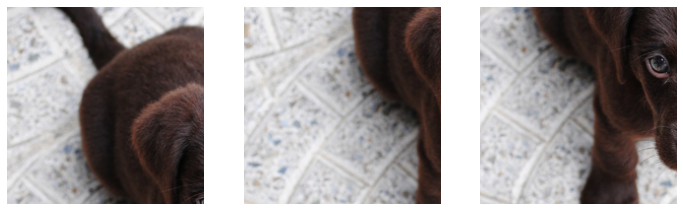

In [ ]:
_,axs = plt.subplots(1,3,figsize=(12,4))
f = RandomCrop(200)
for ax in axs: f(img).show(ctx=ax)

On the validation set, a center crop is always taken.

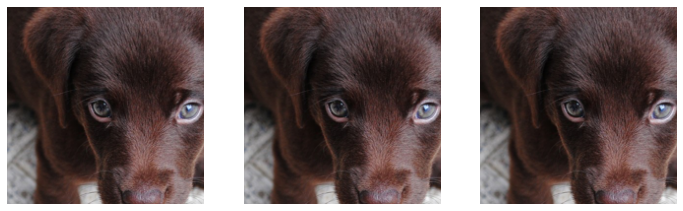

In [ ]:
_,axs = plt.subplots(1,3,figsize=(12,4))
for ax in axs: f(img, split_idx=1).show(ctx=ax)

## CropPad -

In [ ]:
#export
@patch
def encodes(self:CropPad, x: (TensorImage, TensorMask)):
    'Extends CropPad to `TensorImage` & `TensorMask`'
    orig_sz = _get_sz(x)
    tl = (orig_sz-self.size)//2
    return x.crop_pad(self.size, tl, orig_sz=orig_sz, pad_mode=self.pad_mode)

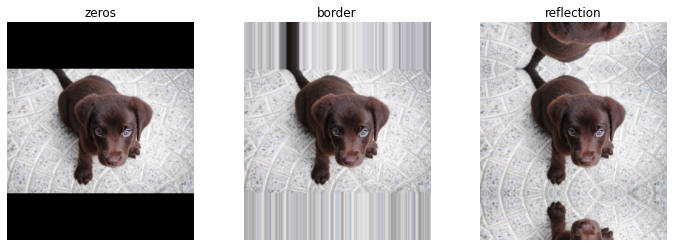

In [ ]:
_,axs = plt.subplots(1,3,figsize=(12,4))
for ax,mode in zip(axs.flatten(), [PadMode.Zeros, PadMode.Border, PadMode.Reflection]):
    img.crop_pad((600,700), pad_mode=mode).show(ctx=ax, title=mode)

## Resize -

In [ ]:
#export
@patch
def encodes(self:Resize, x: (TensorImage, TensorMask)):
    'Extends Resize to `TensorImage` & `TensorMask`'
    orig_sz = _get_sz(x)
    if self.method==ResizeMethod.Squish:
        return x.crop_pad(orig_sz, fastuple(0,0), orig_sz=orig_sz, pad_mode=self.pad_mode,
                resize_mode=self.mode_mask if isinstance(x,TensorMask) else self.mode, resize_to=self.size)

    w,h = orig_sz
    op = (operator.lt,operator.gt)[self.method==ResizeMethod.Pad]
    m = w/self.size[0] if op(w/self.size[0],h/self.size[1]) else h/self.size[1]
    cp_sz = (int(m*self.size[0]),int(m*self.size[1]))
    tl = fastuple(int(self.pcts[0]*(w-cp_sz[0])), int(self.pcts[1]*(h-cp_sz[1])))
    return x.crop_pad(cp_sz, tl, orig_sz=orig_sz, pad_mode=self.pad_mode,
                resize_mode=self.mode_mask if isinstance(x,TensorMask) else self.mode, resize_to=self.size)

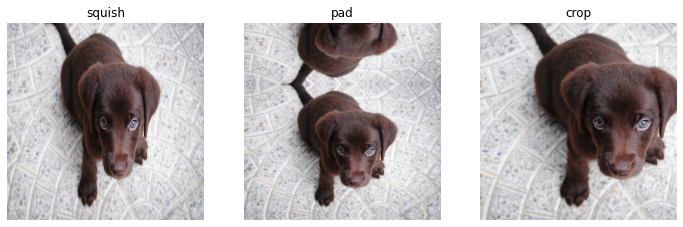

In [ ]:
_,axs = plt.subplots(1,3,figsize=(12,4))
for ax,method in zip(axs.flatten(), [ResizeMethod.Squish, ResizeMethod.Pad, ResizeMethod.Crop]):
    rsz = Resize(256, method=method)
    rsz(img, split_idx=0).show(ctx=ax, title=method)

On the validation set, the crop is always a center crop (on the dimension that's cropped).

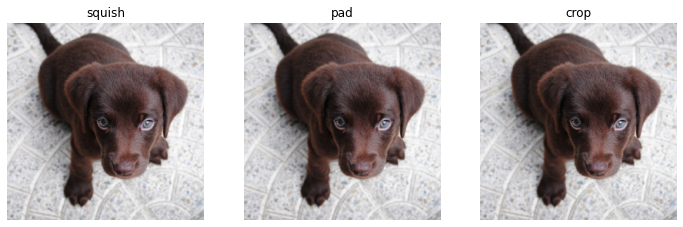

In [ ]:
_,axs = plt.subplots(1,3,figsize=(12,4))
for ax,method in zip(axs.flatten(), [ResizeMethod.Squish, ResizeMethod.Pad, ResizeMethod.Crop]):
    rsz(img, split_idx=1).show(ctx=ax, title=method)

## RandomResizedCrop -

In [ ]:
#export
@patch
def encodes(self:RandomResizedCrop, x: (TensorImage, TensorMask)):
    'Extends RandomResizedCrop to `TensorImage` & `TensorMask`'
    res = x.crop_pad(self.cp_size, self.tl, orig_sz=self.orig_sz,
        resize_mode=self.mode_mask if isinstance(x,TensorMask) else self.mode, resize_to=self.final_size)
    if self.final_size != self.size: res = res.crop_pad(self.size) #Validation set: one final center crop
    return res

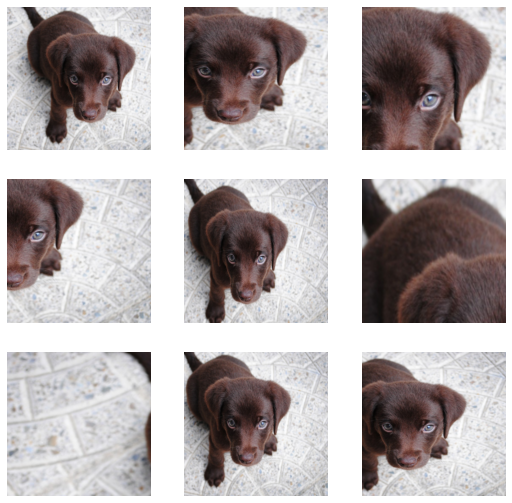

In [ ]:
crop = RandomResizedCrop(256)
_,axs = plt.subplots(3,3,figsize=(9,9))
for ax in axs.flatten():
    crop(img).show(ctx=ax)

On the validation set, center crop the image if it's ratio isn't in the range (to the minmum or maximum value) then resize.

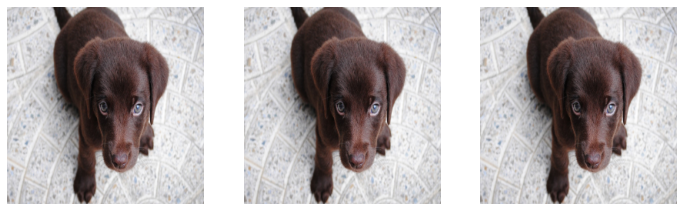

In [ ]:
_,axs = plt.subplots(1,3,figsize=(12,4))
for ax in axs.flatten():
    cropped = crop(img, split_idx=1).show(ctx=ax)

## RatioResize -

In [ ]:
#export
@patch
def encodes(self:RatioResize, x:(TensorImage, TensorMask)):
    'Extends RatioResize to `TensorImage` & `TensorMask`'
    w,h = _get_sz(x)
    if w >= h: nw,nh = self.max_sz,h*self.max_sz/w
    else:      nw,nh = w*self.max_sz/h,self.max_sz
    return Resize(size=(int(nh),int(nw)), resamples=self.resamples)(x)

<AxesSubplot:>

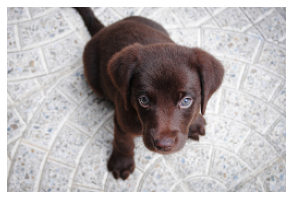

In [ ]:
RatioResize(256)(img).show()

In [ ]:
#hide
#slow
from nbdev.export import notebook2script; notebook2script()

Converted augment.tensor_item_tfm.ipynb.
Converted callback.cutmixup.ipynb.
Converted callback.lr_finder.ipynb.
Converted index.ipynb.
Converted schedulers.fit_flat_varied.ipynb.
